In [1]:
# input: event log without events found in less than 10% of traces (ircc.ipynb)

# abstract_log-starts_ends: original with subprocesses replaced with start/end events
#    (use [start] / [end] tags ; all remaining names with ":" have it replaced by " - " (issues with DCR))
# abstract_log-starts_ends-1: based on shared label substrings; no duplicate events (10s); only variants covering 75%
# abstract_log-starts_ends-2: also with manually identified subprocesses

# lifecycles - level2:
# automatically find subprocesses based on label strings
# (level2, since next level groups the starts/ends of these ones)

# lifecycles - level1:
# manually find subprocesses (still, mostly on label strings)
# (level1, since it groups starts/ends of prior level)
# mostly filtered on variants

In [2]:
import pm4py
import pandas as pd
import numpy as np

# pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

## Find subprocesses based on label strings

In [3]:
log = pd.read_csv("ircc_uOttawa-filter_evt_10p.csv")
log

/var/folders/b6/7128wh613rqcbppftg_0hb2h0000gn/T/ipykernel_95145/705483942.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  log = pd.read_csv("ircc_uOttawa-filter_evt_10p.csv")


,Unnamed: 0,case_id,timestamp,act_upd_by,activity_id,group,cor,event,new_time
0,0,1,2024-06-03 00:00:00.000,CLIENT,0,NaN,Vietnam,Misrepresentation - NIL,1717372800
1,1,1,2024-06-03 00:00:00.000,CLIENT,0,NaN,Vietnam,Eligibility Assessment - NIL,1717372800
2,2,1,2024-06-03 00:00:00.000,CLIENT,0,NaN,Vietnam,Final Assessment - NIL,1717372800
3,3,1,2024-06-03 00:00:00.000,CLIENT,0,NaN,Vietnam,Received - Date,1717372800
4,4,1,2024-06-03 09:20:37.327,EAIMEL,1-SQ1RI5F,NaN,Vietnam,Application Status - Prospective,1717406437
...,...,...,...,...,...,...,...,...,...
525661,543278,7734,2024-06-17 07:46:39.433,SS36358,1-STC2A6X,NaN,Belgium,Other Reqs Assessment - NIL,1718610399
525662,543279,7734,2024-06-26 08:11:25.043,SS36358,1-STC2A6X,NaN,Belgium,Eligibility Assessment - Review Required,1719389485
525663,543280,7734,2024-06-28 10:45:09.050,SS36358,1-STC2A6X,NaN,Belgium,Eligibility Assessment - Failed,1719571509
525664,543281,7734,2024-06-28 10:45:09.587,SS36358,1-STC2A6X,NaN,Belgium,Final Assessment - Refused,1719571509


In [4]:
event_parts = log['event'].apply(lambda e: e.split(" - ")).to_list()
event_parts = pd.DataFrame(event_parts)
event_parts

,0,1,2,3,4
0,Misrepresentation,NIL,None,None,None
1,Eligibility Assessment,NIL,None,None,None
2,Final Assessment,NIL,None,None,None
3,Received,Date,None,None,None
4,Application Status,Prospective,None,None,None
...,...,...,...,...,...
525661,Other Reqs Assessment,NIL,None,None,None
525662,Eligibility Assessment,Review Required,None,None,None
525663,Eligibility Assessment,Failed,None,None,None
525664,Final Assessment,Refused,None,None,None


In [5]:
# event names with more than 2 parts (difficult ones)
troublemakers = event_parts[pd.notna(event_parts[2])][0].unique()
troublemakers

array(['Biometrics', 'Biographic', 'Biometric', 'Criminality',
       'Criminality Assessment'], dtype=object)

In [6]:
# have a closer look at the troublemakers
# for troublemaker in troublemakers:
#     print(event_parts[event_parts[0]==troublemaker].drop_duplicates())

In [7]:
# not troublemaker = easy one!
activ_lifec = event_parts[~ event_parts[0].isin(troublemakers)]

# start from these
activ_lifec = pd.DataFrame({ 'activity': activ_lifec[0], 'lifecycle': activ_lifec[1] })
# activ_lifec

In [8]:
# add "activity_cols" values to activity; add "lifecycle_cols" values to lifecycle
def create_activity_lifecycle(activity_label, activity_cols, lifecycle_cols, event_parts):
    def join_labels(row, cols):
        label = ""
        for col in cols:
             label +=  ((" - " if label != "" else "") + row[col] if pd.notna(row[col]) else "")
        return label
    
    subset = event_parts[event_parts[0]==activity_label]
    activity = subset.apply(lambda row: join_labels(row, activity_cols), axis=1)
    lifecycle = subset.apply(lambda row: join_labels(row, lifecycle_cols), axis=1)
    
    return pd.DataFrame({ 'activity': activity, 'lifecycle': lifecycle})

In [9]:
# for biographics,
# add first two parts to "activity"; add last two parts to "lifecycle"
biometrics_new = create_activity_lifecycle('Biometrics', [0, 1], [2, 3], event_parts)
activ_lifec = pd.concat([activ_lifec, biometrics_new])

# biometrics_new

In [10]:
# for biographic,
# add first part to "activity"; add last three parts to "lifecycle"
biographic_new = create_activity_lifecycle('Biographic', [0], [1, 2, 3], event_parts)
activ_lifec = pd.concat([activ_lifec, biographic_new])

# biographic_new

In [11]:
# for biometric,
# add first three parts to "activity"; add last two parts to "lifecycle"
biometric_new = create_activity_lifecycle('Biometric', [0, 1, 2], [3, 4], event_parts)
activ_lifec = pd.concat([activ_lifec, biometric_new])

# biometric_new

In [12]:
# for the others, 
for idx in range(3, len(troublemakers)):
    troublemaker = troublemakers[idx]
    
    # add first part to "activity"; add last three parts to "lifecycle"
    activity_new = create_activity_lifecycle(troublemaker, [0], [1, 2, 3], event_parts)
    activ_lifec = pd.concat([activ_lifec, activity_new])
    
    # print(activity_new.shape[0])

In [13]:
# drop all 'NIL' lifecycle events
activ_lifec = activ_lifec[activ_lifec['lifecycle']!='NIL']

In [14]:
activ_lifec

,activity,lifecycle
3,Received,Date
4,Application Status,Prospective
5,Biometric Assessment,Required
11,Biometrics Fee,Outstanding
12,Study Permit Fee,Outstanding
...,...,...
525542,Criminality Assessment,Not Started
525544,Criminality Assessment,In Progress
525607,Criminality Assessment,Not Started
525609,Criminality Assessment,In Progress


In [15]:
len(activ_lifec['activity'].unique())

26

In [16]:
# join the "activity" & "lifecycle" to original log
ext_log = log.join(activ_lifec, how='inner') # merge on shared index

# do some checks
# activ_lifec should be same size as original log (not if we filtered activ_lifec)
# print(activ_lifec.shape[0] == log.shape[0])
# join result should have same size as activ_lifec
print(activ_lifec.shape[0] == ext_log.shape[0])
# event should always start with "activity"
check1 = ext_log.apply(lambda row: row['event'].startswith(row['activity']), axis=1)
print(ext_log[~ check1].shape[0]==0)
# event should always include "lifecycle"
check2 = ext_log.apply(lambda row: row['lifecycle'] in row['event'], axis=1)
print(ext_log[~ check2].shape[0]==0)

# prepare for pm
ext_log = ext_log[['case_id', 'timestamp', 'activity', 'lifecycle']]
ext_log = ext_log.rename(columns={ 'case_id': 'case:concept:name', 'lifecycle': 'concept:name', 'timestamp': 'time:timestamp' })
ext_log['case:concept:name'] = ext_log['case:concept:name'].astype(str)
ext_log['time:timestamp'] = pd.to_datetime(ext_log['time:timestamp'])

True
True
True


In [17]:
# just to have a wee look
# pd.options.display.max_rows = 100
# ext_log[ext_log['case:concept:name']=="1"].sort_values(by='time:timestamp')

### Separate subprocesses into separate logs

In [18]:
# but, only do this for activities with >= 3 lifecycle events
activ_lifec_counts = activ_lifec[['activity', 'lifecycle']].drop_duplicates().groupby('activity').count().reset_index().sort_values(by='lifecycle')
activ_lifec_counts

,activity,lifecycle
1,Application Transfer,1
22,Received,1
13,Compliance SP,1
25,Work Permit Fee,2
23,Study Permit Fee,2
21,Other Reqs Assessment,2
20,Medical Assessment,2
19,Medical,2
7,Biometric Assessment,2
17,Final Assessment,2


In [19]:
# (ct'ed)
separ_activ = activ_lifec_counts[activ_lifec_counts['lifecycle']>=3]['activity']
separ_activ

16          Eligibility Assessment
15          Criminality Assessment
14                     Criminality
0               Application Status
3            Auto Promote Decision
12                Candidate Search
8                Biometrics - RCMP
18               Integrated Search
6     Biometric - FCC Detail - USA
4                       Biographic
2                     Auto Promote
24                    Verification
11           Candidate ID Decision
10                    Candidate ID
5            Biometric - FCC - USA
Name: activity, dtype: object

In [20]:
to_separ = ext_log[ext_log['activity'].isin(separ_activ)]
to_separ

,case:concept:name,time:timestamp,activity,concept:name
4,1,2024-06-03 09:20:37.327,Application Status,Prospective
6,1,2024-06-03 09:20:39.023,Criminality,Not Started
7,1,2024-06-03 09:20:39.160,Criminality Assessment,Not Started
8,1,2024-06-03 09:20:39.400,Criminality,In Progress
9,1,2024-06-03 09:20:39.530,Criminality Assessment,In Progress
...,...,...,...,...
525659,7734,2024-06-11 23:52:27.260,Biometric - FCC - USA,NRT
525660,7734,2024-06-17 07:46:39.197,Verification,Completed
525662,7734,2024-06-26 08:11:25.043,Eligibility Assessment,Review Required
525663,7734,2024-06-28 10:45:09.050,Eligibility Assessment,Failed


In [21]:
labeled_logs = [ (g, df) for g, df in to_separ.groupby('activity') ]

In [22]:
# store subprocess logs
# (mine all models, incl. gviz, in separate step)

# from mine_utils import mine_dfg, mine_alpha, mine_heur, mine_induct
import os, shutil

subdir="lifecycles/level2/"

shutil.rmtree(subdir)
os.mkdir(subdir)
os.mkdir(f"{subdir}logs/")

# per activity,
for label, sublog in labeled_logs:
    print(f"{label} (# events: {sublog.shape[0]})")

    # store log
    sublog.to_csv(f"{subdir}/logs/{label.replace('/', '_')}.csv")

Application Status (# events: 23263)
Auto Promote (# events: 29339)
Auto Promote Decision (# events: 22062)
Biographic (# events: 29538)
Biometric - FCC - USA (# events: 29437)
Biometric - FCC Detail - USA (# events: 4529)
Biometrics - RCMP (# events: 25406)
Candidate ID (# events: 29864)
Candidate ID Decision (# events: 23962)
Candidate Search (# events: 23147)
Criminality (# events: 21722)
Criminality Assessment (# events: 21755)
Eligibility Assessment (# events: 10597)
Integrated Search (# events: 30871)
Verification (# events: 26940)


### Aggregate subprocesses in the overall log

In [23]:
# per case, for the subprocesses, replace all activity lifecycle events by single start & end event

sorted_grouped = to_separ.sort_values(['case:concept:name', 'activity', 'time:timestamp']).groupby(['case:concept:name', 'activity'])
start_evts = sorted_grouped.first().reset_index(); start_evts['concept:name'] = start_evts['activity'] + ' [start]'
end_evts = sorted_grouped.last().reset_index(); end_evts['concept:name'] = end_evts['activity'] + ' [end]'
abstract_log = pd.concat([start_evts, end_evts])
# abstract_log = end_evts 

In [24]:
# re-add the non-subprocess activities

not_separ = ext_log[~ext_log['activity'].isin(separ_activ)]
not_separ['concept:name'] = not_separ['activity'] + " - " + not_separ['concept:name']
abstract_log = pd.concat([ abstract_log, not_separ ], ignore_index=True).sort_values(by=['case:concept:name','time:timestamp'])

## Delete duplicate events

In [25]:
# delete 'duplicate' events, i.e., same events in a trace occurring within x seconds of each other

# NOTE assumes that timestamps are sorted within each group
diff = abstract_log.groupby(['case:concept:name', 'concept:name'])['time:timestamp'].diff().astype(int)
abstract_log['diff'] = diff
abstract_log[abstract_log['diff']>0]

,case:concept:name,activity,time:timestamp,concept:name,diff
209338,1,Biometrics Fee,2024-06-03 09:20:46,Biometrics Fee - Outstanding,1000000000
209339,1,Study Permit Fee,2024-06-03 09:20:46,Study Permit Fee - Outstanding,1000000000
209340,1,Biometrics Fee,2024-06-03 09:20:46,Biometrics Fee - Paid,1000000000
209341,1,Study Permit Fee,2024-06-03 09:20:46,Study Permit Fee - Paid,1000000000
209507,10,Biometrics Fee,2024-06-03 11:09:30,Biometrics Fee - Outstanding,2000000000
...,...,...,...,...,...
228036,998,Work Permit Fee,2024-06-05 15:42:44,Work Permit Fee - Exempt,121810000000000
228048,999,Study Permit Fee,2024-06-04 05:52:54,Study Permit Fee - Outstanding,26000000000
228049,999,Biometrics Fee,2024-06-04 05:52:54,Biometrics Fee - Outstanding,26000000000
228050,999,Study Permit Fee,2024-06-04 05:52:54,Study Permit Fee - Paid,26000000000


In [26]:
# drop duplicate events with time difference less than max_diff
max_diff = 10
billion=pow(10,9) # get diffs in seconds
to_drop = abstract_log[(abstract_log['diff']>0) & (abstract_log['diff']<max_diff*billion)].index
to_drop

Int64Index([209338, 209339, 209340, 209341, 209507, 209508, 209509, 209510,
            211191, 211192,
            ...
            227981, 227982, 227983, 227984, 227998, 227999, 228000, 228001,
            228002, 228003],
           dtype='int64', length=23489)

In [27]:
abstract_log2 = abstract_log[~abstract_log.index.isin(to_drop)]
abstract_log2

,case:concept:name,activity,time:timestamp,concept:name,diff
209332,1,Received,2024-06-03 00:00:00.000,Received - Date,-9223372036854775808
0,1,Application Status,2024-06-03 09:20:37.327,Application Status [start],-9223372036854775808
209333,1,Biometric Assessment,2024-06-03 09:20:38.890,Biometric Assessment - Required,-9223372036854775808
9,1,Criminality,2024-06-03 09:20:39.023,Criminality [start],-9223372036854775808
10,1,Criminality Assessment,2024-06-03 09:20:39.160,Criminality Assessment [start],-9223372036854775808
...,...,...,...,...,...
209331,999,Verification,2024-06-15 07:27:08.453,Verification [end],-9223372036854775808
104663,999,Eligibility Assessment,2024-07-01 12:26:39.677,Eligibility Assessment [start],-9223372036854775808
209329,999,Eligibility Assessment,2024-07-01 12:26:39.677,Eligibility Assessment [end],-9223372036854775808
228053,999,Final Assessment,2024-08-13 12:48:58.593,Final Assessment - Refused,-9223372036854775808


In [28]:
abstract_log2 = abstract_log2[['case:concept:name', 'concept:name', 'time:timestamp']]

# abstract_log2[abstract_log2['case:concept:name']=="1"].sort_values(by='time:timestamp')

In [29]:
# (cope with timestamps that are a few seconds from each other)

# diff = abstract_log2.groupby(['case:concept:name'])['time:timestamp'].diff().astype(int)
# abstract_log2['diff'] = diff
# abstract_log2[abstract_log2['diff']>0]

# max_diff = 10
# billion=pow(10,9) # get diffs in seconds
# to_drop = abstract_log[(abstract_log['diff']>0) & (abstract_log['diff']<max_diff*billion)].index
# to_drop

# abstract_log2 = abstract_log[~abstract_log.index.isin(to_drop)]
# abstract_log2

### Ad-hoc aggregation of events (unused)

In [30]:
# from mine_utils import aggregate_events_replace_last

# abstract_log3 = abstract_log2.copy() #abstract_log2[abstract_log2['case:concept:name'].isin(["1","2","3"])]

In [31]:
# activs = abstract_log3['concept:name'].unique()

In [32]:
# fees_out = [ a for a in activs if "Outstanding" in a ]
# print(fees_out)
# abstract_log3 = aggregate_events_replace_last(abstract_log3, fees_out, "Outstanding:last", False)

In [33]:
# fees_paid_exm = [ a for a in activs if "Paid" in a or "Exempt" in a ]
# print(fees_paid_exm)
# abstract_log3 = aggregate_events_replace_last(abstract_log3, fees_paid_exm, "Paid_Exm:last", False)

In [34]:
# have a wee look
# abstract_log3[abstract_log3['case:concept:name'].isin(["3"])]

In [35]:
# size0 = abstract_log2.shape[0]
# size1 = size0 - ((2.352875040154192 - 1) * 12452) - ((2.3639868744872845 - 1) * 12190)

# print("expected:", size1)
# print("actual:", abstract_log3.shape[0])

## Filter out infrequent variants

In [36]:
from log_stats import get_trace_lengths
get_trace_lengths('concept:name', 'case:concept:name', abstract_log2, plot=False).describe()

count    7734.000000
mean       42.522110
std         7.491948
min         8.000000
25%        39.000000
50%        43.000000
75%        47.000000
max       132.000000
Name: concept:name, dtype: float64

In [37]:
len(abstract_log2['case:concept:name'].unique())

7734

In [38]:
from variant_stats import get_variants_stats, get_variant_coverage, get_covering_variants, filter_traces_on_variants

In [39]:
var_stats = get_variants_stats(abstract_log2)
var_stats

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",30,0.387898,0.387898,0.015555
1,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",29,0.374968,0.762865,0.031109
2,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",22,0.284458,1.047324,0.046664
3,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",22,0.284458,1.331782,0.062218
4,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",15,0.193949,1.525731,0.077773
...,...,...,...,...,...
6424,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",1,0.012930,99.948280,99.937782
6425,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",1,0.012930,99.961210,99.953336
6426,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",1,0.012930,99.974140,99.968891
6427,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",1,0.012930,99.987070,99.984445


In [40]:
vars = get_covering_variants(75, var_stats)
vars
# vars = var_stats[var_stats['cov_perc']>=1]
# vars

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",30,0.387898,0.387898,0.015555
1,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",29,0.374968,0.762865,0.031109
2,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",22,0.284458,1.047324,0.046664
3,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",22,0.284458,1.331782,0.062218
4,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",15,0.193949,1.525731,0.077773
...,...,...,...,...,...
4490,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",1,0.012930,74.941815,69.855343
4491,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Biometrics Fee - Outstanding, Study P...",1,0.012930,74.954745,69.870897
4492,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Study Permit Fee - Outstanding, Biome...",1,0.012930,74.967675,69.886452
4493,"(Received - Date, Application Status [start], Biometric Assessment - Required, Criminality [start], Criminality Assessment [start], Biometrics - RCMP [start], Study Permit Fee - Outstanding, Study...",1,0.012930,74.980605,69.902007


In [41]:
# filter on 0.1% cov_perc: 14% remaining
# filter on 1% cov perc: 48% remaining

print("remaining coverage:", vars['cov_perc'].sum())

remaining coverage: 74.99353504008275


In [42]:
abstract_log3 = filter_traces_on_variants(abstract_log2, vars)
abstract_log3

,case:concept:name,concept:name,time:timestamp
0,1,Received - Date,2024-06-03 00:00:00.000
1,1,Application Status [start],2024-06-03 09:20:37.327
2,1,Biometric Assessment - Required,2024-06-03 09:20:38.890
3,1,Criminality [start],2024-06-03 09:20:39.023
4,1,Criminality Assessment [start],2024-06-03 09:20:39.160
...,...,...,...
328822,998,Application Transfer - Transferred,2024-06-17 19:09:06.000
328823,998,Eligibility Assessment [start],2024-06-24 15:41:48.947
328824,998,Eligibility Assessment [end],2024-06-24 15:41:48.947
328825,998,Final Assessment - Refused,2024-06-24 20:54:19.710


In [43]:
abstract_log3.to_csv("abstract_log-starts_ends-v1.csv")

In [44]:
import pm4py.objects.log.exporter.xes.exporter as xes_export
# xes_export.apply(abstract_log4, "abstract_log-starts_ends-1.xes")

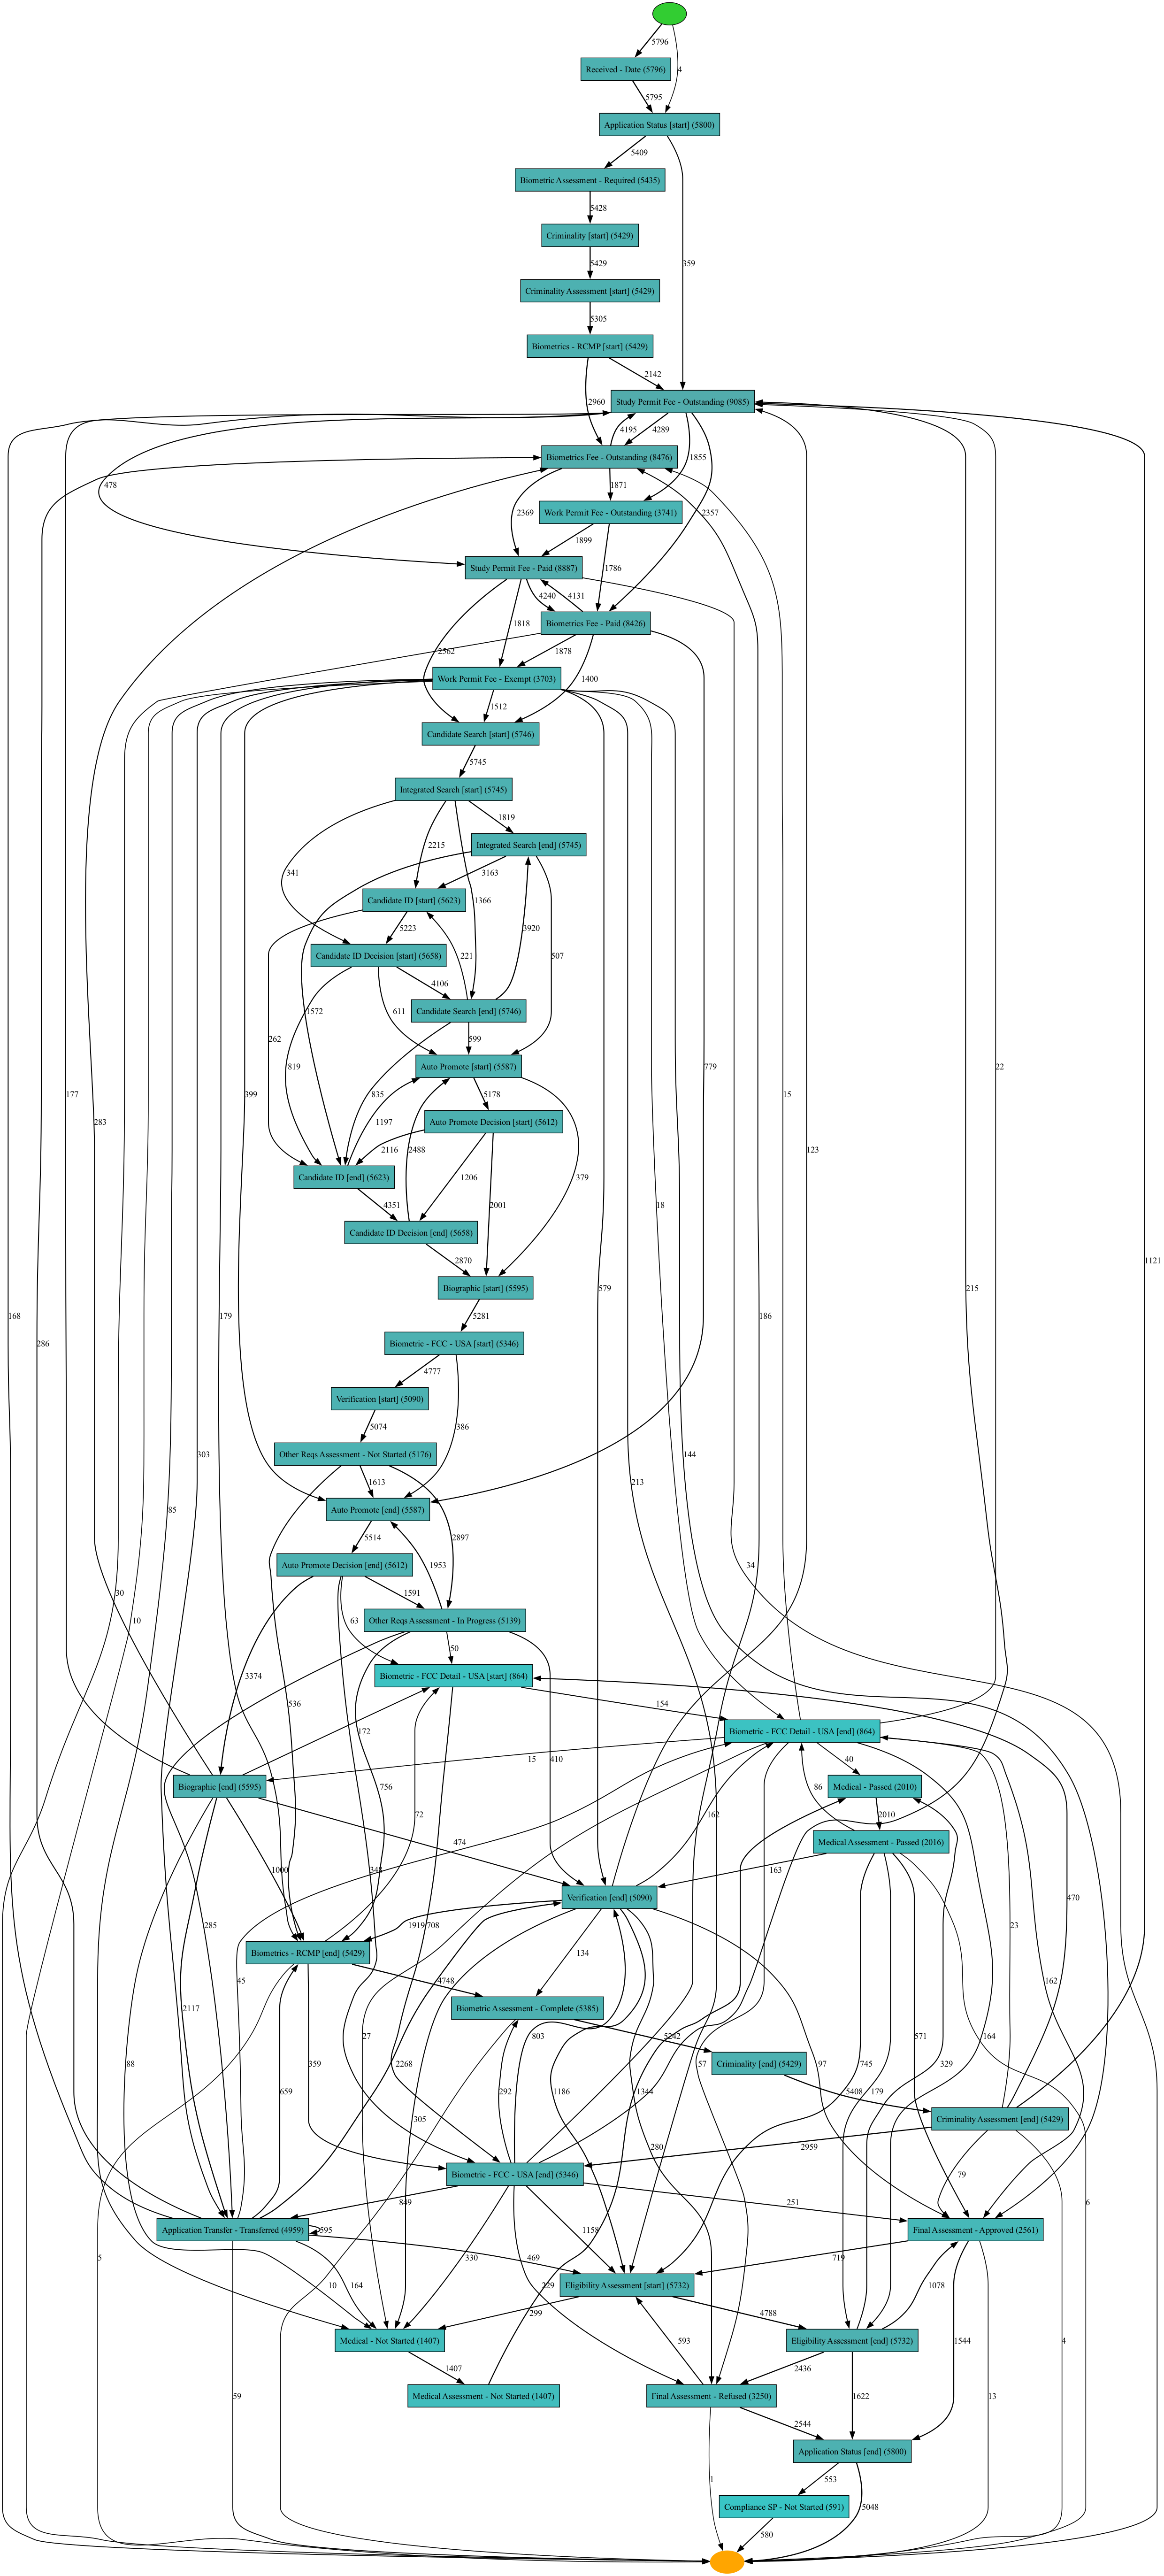

In [45]:
from mine_utils import mine_heur

mine_heur(abstract_log3)

## Manually find subprocesses 

'candidate' & 'integrated' search events
why this choice? they all seem to start and end at more or less the same event, with a bunch of spaghetti in between
and, they have similar names ...
so, still kind of considering labels
can still consider replacing all these events with single "sub"event, since they have complicated relations with other events (in particular, auto-promote and such);

tried frequent itemset mining to get frequent combinations of subset's events (ircc-simult)
in the end, simply considered all subset's events together
(was mucking about with individual pairs; if simult, ensuring a particular ordering; didn't make much difference & labor intensive)

with all events taken together, they are "simulteneous" (within 10min) in 75% cases
eventually, removed all "simultaneous" events from the log to get "real" orderings
-> log3

looking at variants _per log subset_ 
turned out a good idea; zoomed in on certain parts
after checking the discovered petri net & variants, it seemed the following holds, more or less:
cand search:start -> integr search:start -> integr search:end -> cand search:end
 										    cand id:start ~> cand id dec:start -> cand id:end ~> cand id dec:end

used declare miner (RuM tool) - it finds more or less the same constraints; especially when looking at the automaton
but difficult to read ... it seems some of the constraints are inferrable (transitivity; X r Y r Z -> X r Z)
-> search-found-rum-automaton, search-found-rum-constraints

(declarepy goes completely off the deep end for same log; search-found-decl4py-constraints)

manually created a more minimal decl model based on the above
-> search-manual-loose (not fully compliant), search-manual-strict (full compliance)

dcr4py: much better & minimal model - 100% corresponds to hand-drawn one!



'biographic' & 'biometric' events (minus 'fees')
~same criteria for choice as before ("start" and "end" events are not as clear)

not as much luck with simultaneous events
variants (log3) were not very enlightening either

dcr4py: got minimal model that corresponds a bit to inductive miner output



subset of 'medical' events
purely based on labels here

95% of events are simultaneous (within 10 minutes; 92% within 1 minute)
only 8 variants

makes most sense:
(o) Medical:Not Started -> Medical Assessment:Not Started -> Medical:Passed, Medical Assessment:Passed -> (o)
														  -> skip -> (o)



'criminality' events
purely on labels

only 2 variants; 1 with a coverage of 1
quite simple!



'fee' (outstanding / paid) events
purely on labels

mostly same timestamps (99.5 are absolutely identical)
so, would keep ordering b/w outstanding/paid pairs, but nothing else

In [46]:
log = abstract_log3

In [47]:
import os, shutil

subdir = "lifecycles/level1"

def init_subdir(subdir):
    if os.path.exists(subdir):
        shutil.rmtree(subdir)
    os.mkdir(subdir)
    
init_subdir(os.path.join(subdir, "logs"))
init_subdir(os.path.join(subdir, "xes"))

### Candidate / Integrated search

In [48]:
log2 = log[(log['concept:name'].str.contains("Candidate")) | log['concept:name'].str.contains("Integrated")]
log2

,case:concept:name,concept:name,time:timestamp
10,1,Candidate Search [start],2024-06-03 09:20:48
11,1,Integrated Search [start],2024-06-03 09:20:48
12,1,Integrated Search [end],2024-06-03 09:20:54
13,1,Candidate ID [start],2024-06-03 09:20:55
14,1,Candidate ID Decision [start],2024-06-03 09:20:55
...,...,...,...
328789,998,Candidate ID Decision [start],2024-06-04 05:52:04
328790,998,Candidate Search [end],2024-06-04 05:52:04
328791,998,Integrated Search [end],2024-06-04 05:52:04
328792,998,Candidate ID [end],2024-06-04 05:52:06


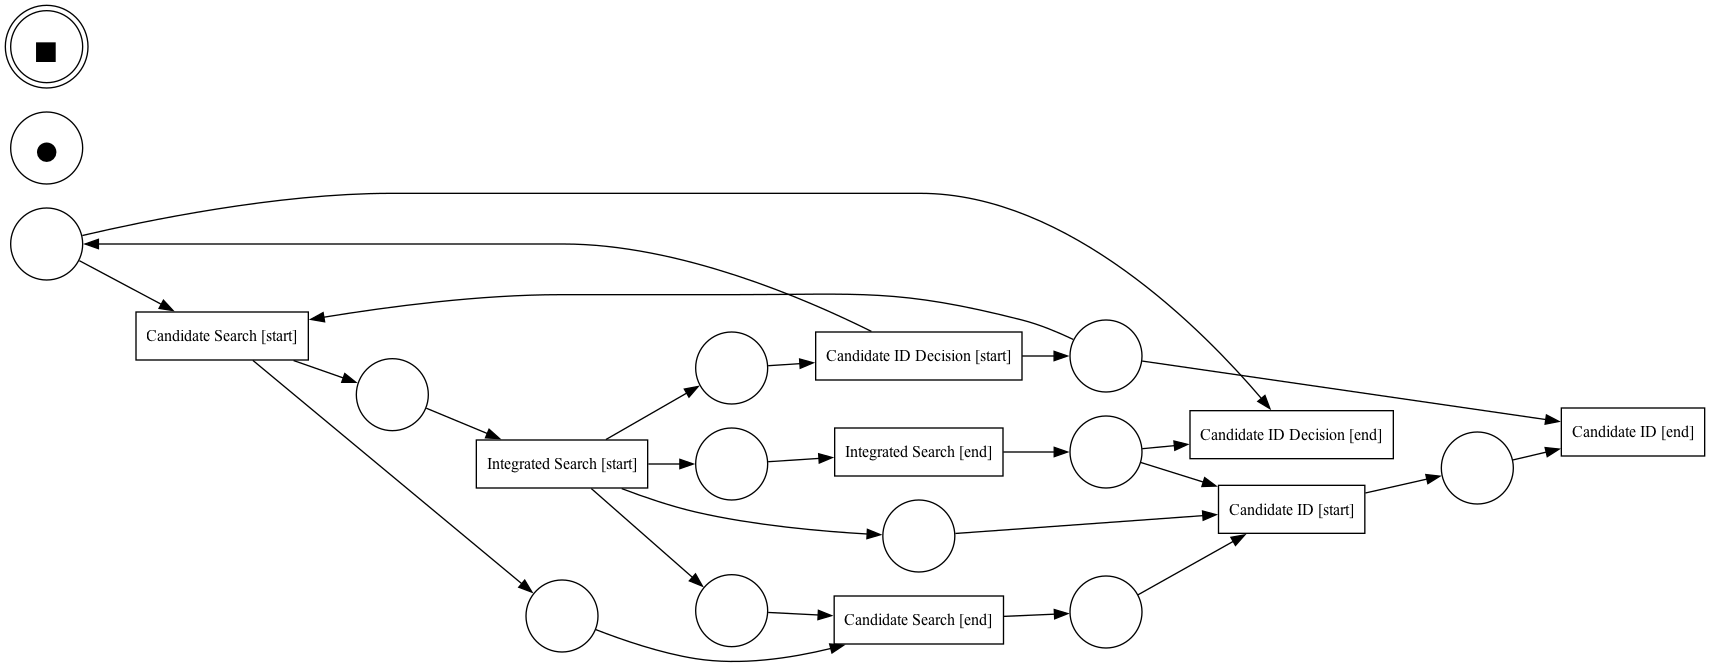

In [49]:
from mine_utils import mine_alpha
mine_alpha(log2)

In [50]:
# log2.to_csv("lifecycles/level1/logs/Candidate_Integrated Search-all.csv")
# xes_export.apply(log2, "lifecycles/level1/xes/Candidate_Integrated Search-all.xes")

In [51]:
itemset = log2['concept:name'].unique()
itemset

array(['Candidate Search [start]', 'Integrated Search [start]',
       'Integrated Search [end]', 'Candidate ID [start]',
       'Candidate ID Decision [start]', 'Candidate Search [end]',
       'Candidate ID [end]', 'Candidate ID Decision [end]'], dtype=object)

In [52]:
from mine_utils import aggregate_events

max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
# groups: 5746 total size: 45544 avg size: 7.93
# groups: 5746 # simult: 4333 avg: 75.41 %
# groups: 5746 avg_diff: 23679 s ( 394 m )


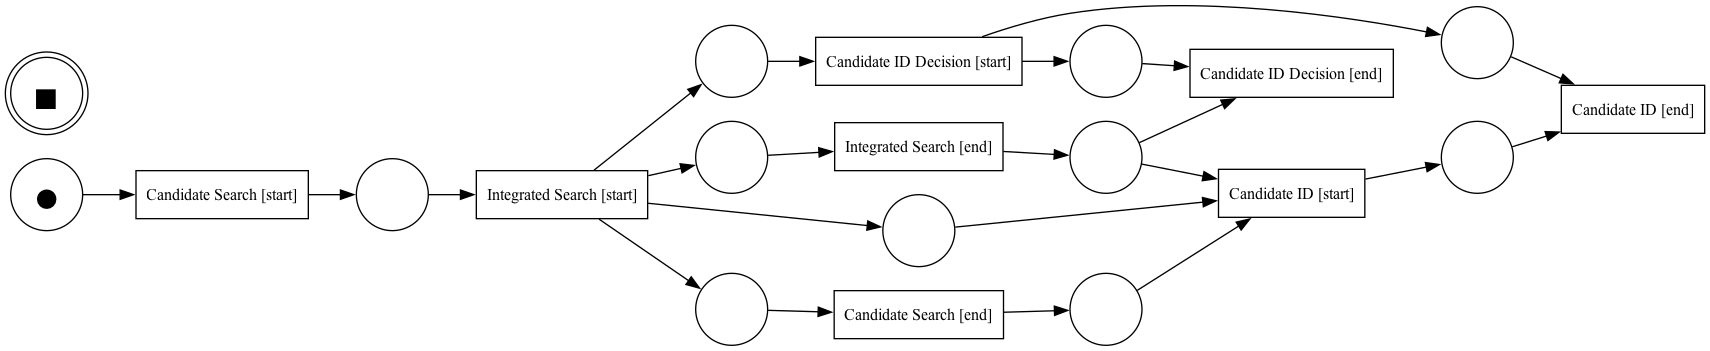

In [53]:
from mine_utils import mine_alpha
mine_alpha(log3)

# better!

In [54]:
log2.to_csv("lifecycles/level1/logs/Candidate_Integrated Search.csv")
xes_export.apply(log2, "lifecycles/level1/xes/Candidate_Integrated Search.xes")

exporting log, completed traces ::   0%|          | 0/5746 [00:00<?, ?it/s]

In [55]:
# traces = log2.groupby('case:concept:name')['concept:name'].apply(tuple).to_list()
# traces

### Biometric / Biographic

In [56]:
log2 = log[((log['concept:name'].str.contains("Biometric")) | log['concept:name'].str.contains("Biographic")) & (~ log['concept:name'].str.contains("Fee"))]
log2

,case:concept:name,concept:name,time:timestamp
2,1,Biometric Assessment - Required,2024-06-03 09:20:38.890
5,1,Biometrics - RCMP [start],2024-06-03 09:20:39.693
22,1,Biographic [start],2024-06-03 16:33:10.917
23,1,Biometric - FCC - USA [start],2024-06-03 16:33:11.900
27,1,Biographic [end],2024-06-03 16:39:54.950
...,...,...,...
328797,998,Biometric - FCC - USA [start],2024-06-04 05:52:13.213
328801,998,Biometrics - RCMP [end],2024-06-04 05:52:31.587
328802,998,Biometric Assessment - Complete,2024-06-04 05:52:31.790
328813,998,Biographic [end],2024-06-04 06:01:13.837


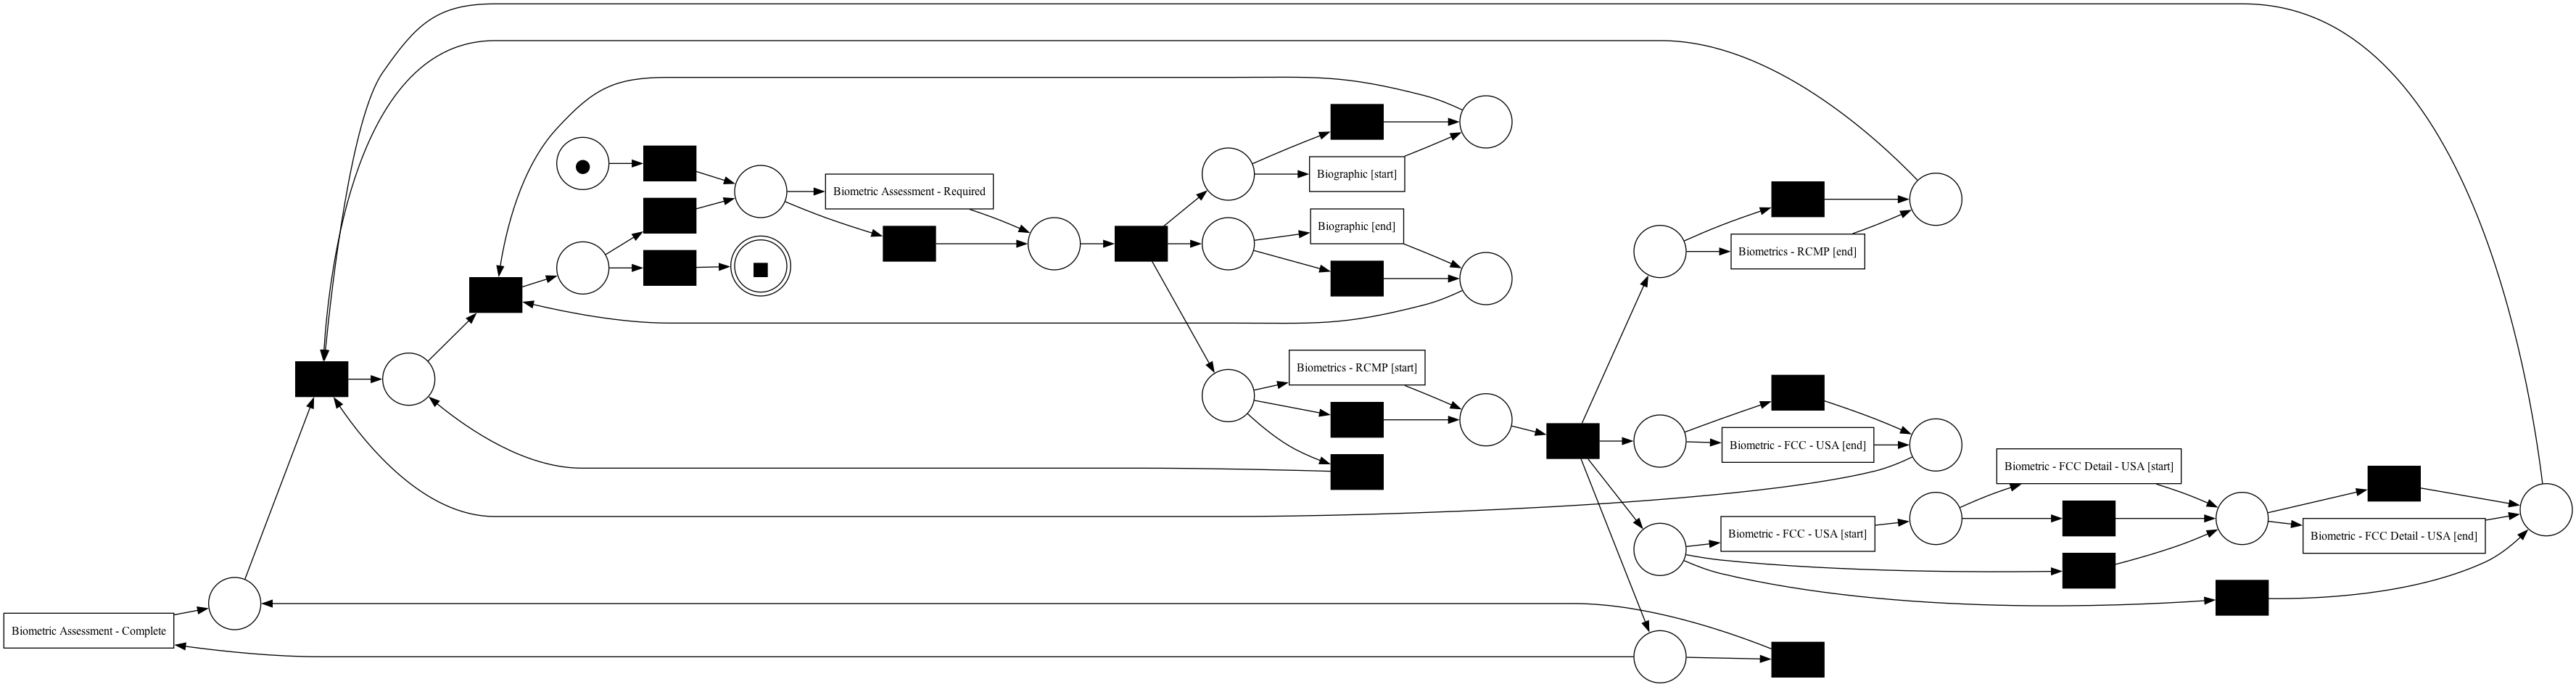

In [57]:
from mine_utils import mine_induct
mine_induct(log2)

In [58]:
# log2.to_csv("lifecycles/level1/logs/Biometric_Biographic-all.csv")
# xes_export.apply(log2, "lifecycles/level1/xes/Biometric_Biographic-all.xes") 

In [59]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
var_stats

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Biometric Assessment - Required, Biometrics - RCMP [start], Biographic [start], Biometric - FCC - USA [start], Biographic [end], Biometrics - RCMP [end], Biometric Assessment - Complete, Biometri...",2944,51.739895,51.739895,1.162791
1,"(Biometric Assessment - Required, Biometrics - RCMP [start], Biographic [start], Biometric - FCC - USA [start], Biometrics - RCMP [end], Biometric Assessment - Complete, Biographic [end], Biometri...",474,8.330404,60.070299,2.325581
2,"(Biometric Assessment - Required, Biometrics - RCMP [start], Biographic [start], Biometric - FCC - USA [start], Biometrics - RCMP [end], Biometric Assessment - Complete, Biometric - FCC - USA [end...",453,7.961336,68.031634,3.488372
3,"(Biometric Assessment - Required, Biometrics - RCMP [start], Biographic [start], Biometric - FCC - USA [start], Biographic [end], Biometrics - RCMP [end], Biometric Assessment - Complete, Biometri...",394,6.924429,74.956063,4.651163
4,"(Biometric Assessment - Required, Biometrics - RCMP [start], Biographic [start], Biometric - FCC - USA [start], Biographic [end], Biometrics - RCMP [end], Biometric - FCC - USA [end], Biometric As...",338,5.940246,80.896309,5.813953
...,...,...,...,...,...
81,"(Biometric Assessment - Required, Biometrics - RCMP [start], Biographic [start], Biographic [end], Biometrics - RCMP [end], Biometric Assessment - Complete, Biometric - FCC - USA [start], Biometri...",1,0.017575,99.929701,95.348837
82,"(Biometric Assessment - Required, Biometrics - RCMP [start], Biometrics - RCMP [end], Biographic [start], Biometric - FCC - USA [start], Biographic [end], Biometric Assessment - Complete, Biometri...",1,0.017575,99.947276,96.511628
83,"(Biometric Assessment - Required, Biometrics - RCMP [start], Biographic [start], Biometric - FCC - USA [start], Biometric Assessment - Complete, Biometric - FCC Detail - USA [start], Biometric - F...",1,0.017575,99.964851,97.674419
84,"(Biometric Assessment - Required, Biometrics - RCMP [start], Biographic [start], Biometric - FCC - USA [start], Biometrics - RCMP [end], Biometric - FCC Detail - USA [start], Biometric - FCC Detai...",1,0.017575,99.982425,98.837209


In [60]:
cov_var = get_covering_variants(90, var_stats)
log3 = filter_traces_on_variants(log2, cov_var)

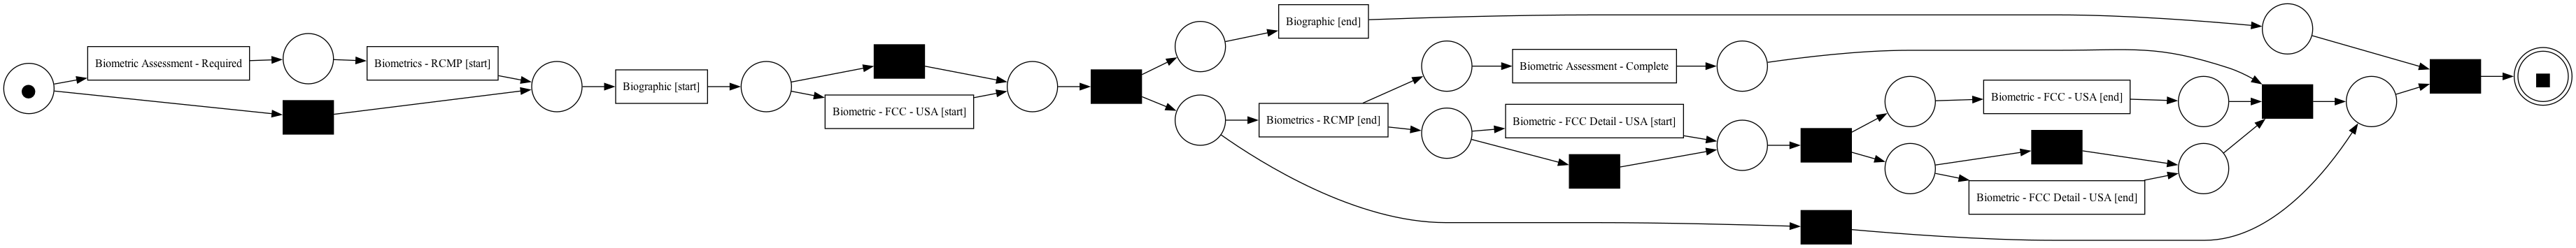

In [61]:
mine_induct(log3)

In [62]:
log3.to_csv("lifecycles/level1/logs/Biometric_Biographic.csv")
xes_export.apply(log3, "lifecycles/level1/xes/Biometric_Biographic.xes") 

exporting log, completed traces ::   0%|          | 0/5051 [00:00<?, ?it/s]

### Medical

In [63]:
log2 = log[log['concept:name'].str.contains("Medical")]
log2

,case:concept:name,concept:name,time:timestamp
36,1,Medical - Passed,2024-07-24 21:24:32.723
37,1,Medical Assessment - Passed,2024-07-24 21:24:32.850
140,1000,Medical - Passed,2024-07-12 15:00:44.590
141,1000,Medical Assessment - Passed,2024-07-12 15:00:44.790
434,1007,Medical - Passed,2024-07-12 15:18:40.050
...,...,...,...
328561,992,Medical Assessment - Passed,2024-07-12 17:28:22.557
328642,994,Medical - Not Started,2024-07-15 11:54:53.780
328643,994,Medical Assessment - Not Started,2024-07-15 11:54:53.920
328644,994,Medical - Passed,2024-07-15 11:55:13.630


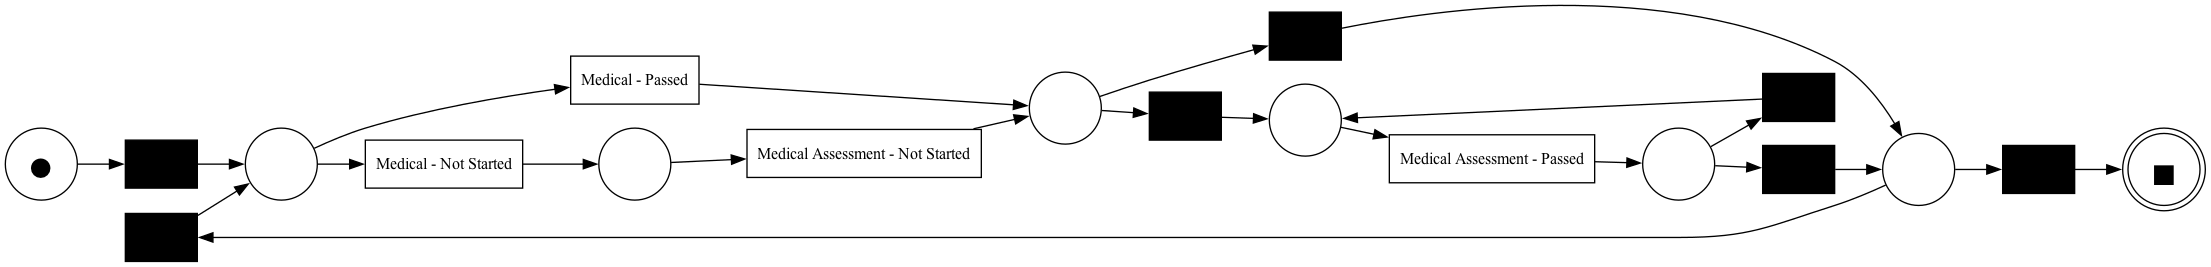

In [64]:
from mine_utils import mine_induct
mine_induct(log2)

In [65]:
# log2.to_csv("lifecycles/level1/logs/Medical (Assessment)-all.csv")
# xes_export.apply(log2, "lifecycles/level1/xes/Medical (Assessment)-all.xes") 

In [66]:
itemset = log2['concept:name'].unique()

from mine_utils import aggregate_events

max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

# most are simultaneous ...

5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
# groups: 2044 total size: 6840 avg size: 3.35
# groups: 2044 # simult: 1951 avg: 95.45 %
# groups: 2044 avg_diff: 26615 s ( 443 m )


In [67]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
var_stats

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Medical - Not Started, Medical Assessment - Not Started, Medical - Passed, Medical Assessment - Passed)",1350,66.864785,66.864785,11.111111
1,"(Medical - Passed, Medical Assessment - Passed)",627,31.054978,97.919762,22.222222
2,"(Medical - Not Started, Medical Assessment - Not Started)",17,0.842001,98.761763,33.333333
3,"(Medical - Not Started, Medical Assessment - Not Started, Medical - Not Started, Medical Assessment - Not Started, Medical - Passed, Medical Assessment - Passed)",11,0.544824,99.306587,44.444444
4,"(Medical - Not Started, Medical Assessment - Not Started, Medical - Passed, Medical Assessment - Passed, Medical Assessment - Passed)",5,0.247647,99.554235,55.555556
5,"(Medical - Not Started, Medical Assessment - Not Started, Medical - Passed, Medical Assessment - Passed, Medical - Passed, Medical Assessment - Passed)",4,0.198118,99.752353,66.666667
6,"(Medical - Not Started, Medical Assessment - Not Started, Medical - Passed, Medical Assessment - Passed, Medical - Not Started, Medical Assessment - Not Started, Medical - Passed, Medical Assessme...",3,0.148588,99.900941,77.777778
7,"(Medical - Not Started, Medical Assessment - Not Started, Medical - Passed, Medical Assessment - Passed, Medical - Not Started, Medical Assessment - Not Started, Medical Assessment - Passed)",1,0.049529,99.950471,88.888889
8,"(Medical - Passed, Medical Assessment - Passed, Medical - Not Started, Medical Assessment - Not Started, Medical - Passed, Medical Assessment - Passed)",1,0.049529,100.000000,100.000000


In [68]:
vars = var_stats.iloc[0:4]
log3 = filter_traces_on_variants(log2, vars)
log3

,case:concept:name,concept:name,time:timestamp
0,1,Medical - Passed,2024-07-24 21:24:32.723
1,1,Medical Assessment - Passed,2024-07-24 21:24:32.850
2,1000,Medical - Passed,2024-07-12 15:00:44.590
3,1000,Medical Assessment - Passed,2024-07-12 15:00:44.790
4,1007,Medical - Passed,2024-07-12 15:18:40.050
...,...,...,...
6835,992,Medical Assessment - Passed,2024-07-12 17:28:22.557
6836,994,Medical - Not Started,2024-07-15 11:54:53.780
6837,994,Medical Assessment - Not Started,2024-07-15 11:54:53.920
6838,994,Medical - Passed,2024-07-15 11:55:13.630


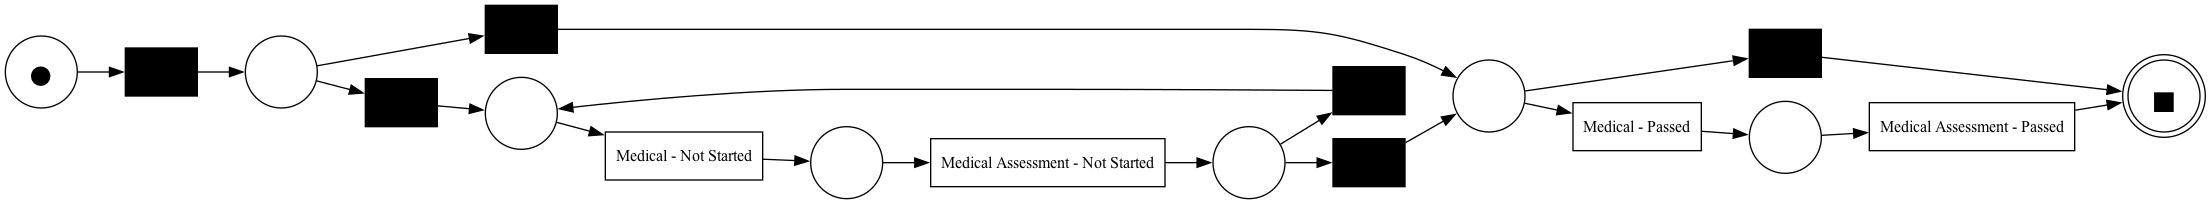

In [69]:
from mine_utils import mine_induct
mine_induct(log3)

In [70]:
log3.to_csv("lifecycles/level1/logs/Medical (Assessment).csv")
xes_export.apply(log3, "lifecycles/level1/xes/Medical (Assessment).xes") 

exporting log, completed traces ::   0%|          | 0/2005 [00:00<?, ?it/s]

### Criminality

In [71]:
log2 = log[log['concept:name'].str.contains("Criminality")]
log2

,case:concept:name,concept:name,time:timestamp
3,1,Criminality [start],2024-06-03 09:20:39.023
4,1,Criminality Assessment [start],2024-06-03 09:20:39.160
31,1,Criminality [end],2024-06-30 00:45:58.623
32,1,Criminality Assessment [end],2024-06-30 00:45:58.793
82,100,Criminality [start],2024-06-03 11:51:35.130
...,...,...,...
328768,997,Criminality Assessment [end],2024-06-30 16:00:39.843
328777,998,Criminality [start],2024-06-04 05:51:42.913
328778,998,Criminality Assessment [start],2024-06-04 05:51:43.060
328803,998,Criminality [end],2024-06-04 05:52:32.433


In [72]:
# log2.to_csv("lifecycles/level1/logs/Criminality (Assessment)-all.csv")
# xes_export.apply(log2, "lifecycles/level1/xes/Criminality (Assessment)-all.xes")

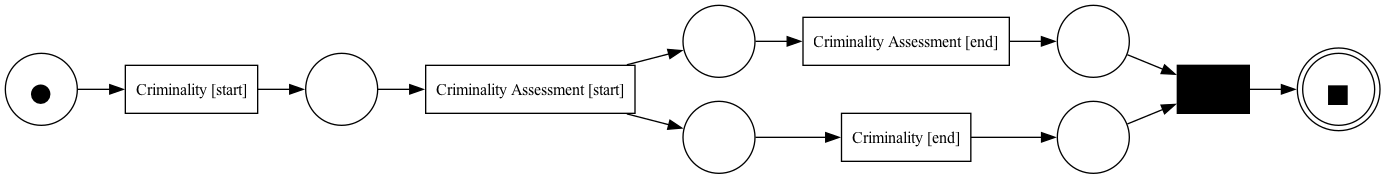

In [73]:
from mine_utils import mine_induct
mine_induct(log2)

In [74]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
var_stats

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Criminality [start], Criminality Assessment [start], Criminality [end], Criminality Assessment [end])",5428,99.98158,99.98158,50.0
1,"(Criminality [start], Criminality Assessment [start], Criminality Assessment [end], Criminality [end])",1,0.01842,100.00000,100.0


In [75]:
vars = get_covering_variants(99.99, var_stats)
log3 = filter_traces_on_variants(log2, vars)
log3

,case:concept:name,concept:name,time:timestamp
0,1,Criminality [start],2024-06-03 09:20:39.023
1,1,Criminality Assessment [start],2024-06-03 09:20:39.160
2,1,Criminality [end],2024-06-30 00:45:58.623
3,1,Criminality Assessment [end],2024-06-30 00:45:58.793
4,100,Criminality [start],2024-06-03 11:51:35.130
...,...,...,...
21711,997,Criminality Assessment [end],2024-06-30 16:00:39.843
21712,998,Criminality [start],2024-06-04 05:51:42.913
21713,998,Criminality Assessment [start],2024-06-04 05:51:43.060
21714,998,Criminality [end],2024-06-04 05:52:32.433


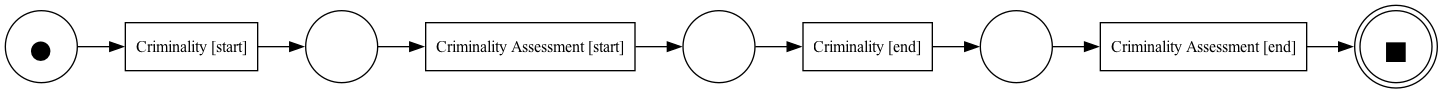

In [76]:
from mine_utils import mine_induct
mine_induct(log3)

In [77]:
log3.to_csv("lifecycles/level1/logs/Criminality (Assessment).csv")
xes_export.apply(log3, "lifecycles/level1/xes/Criminality (Assessment).xes")

exporting log, completed traces ::   0%|          | 0/5428 [00:00<?, ?it/s]

### Fees

In [78]:
log2 = log[log['concept:name'].str.contains("Fee")]
log2

,case:concept:name,concept:name,time:timestamp
6,1,Biometrics Fee - Outstanding,2024-06-03 09:20:45
7,1,Study Permit Fee - Outstanding,2024-06-03 09:20:45
8,1,Biometrics Fee - Paid,2024-06-03 09:20:45
9,1,Study Permit Fee - Paid,2024-06-03 09:20:45
85,100,Biometrics Fee - Outstanding,2024-06-03 11:52:59
...,...,...,...
328815,998,Biometrics Fee - Outstanding,2024-06-05 15:42:44
328816,998,Work Permit Fee - Outstanding,2024-06-05 15:42:44
328817,998,Study Permit Fee - Paid,2024-06-05 15:42:44
328818,998,Biometrics Fee - Paid,2024-06-05 15:42:44


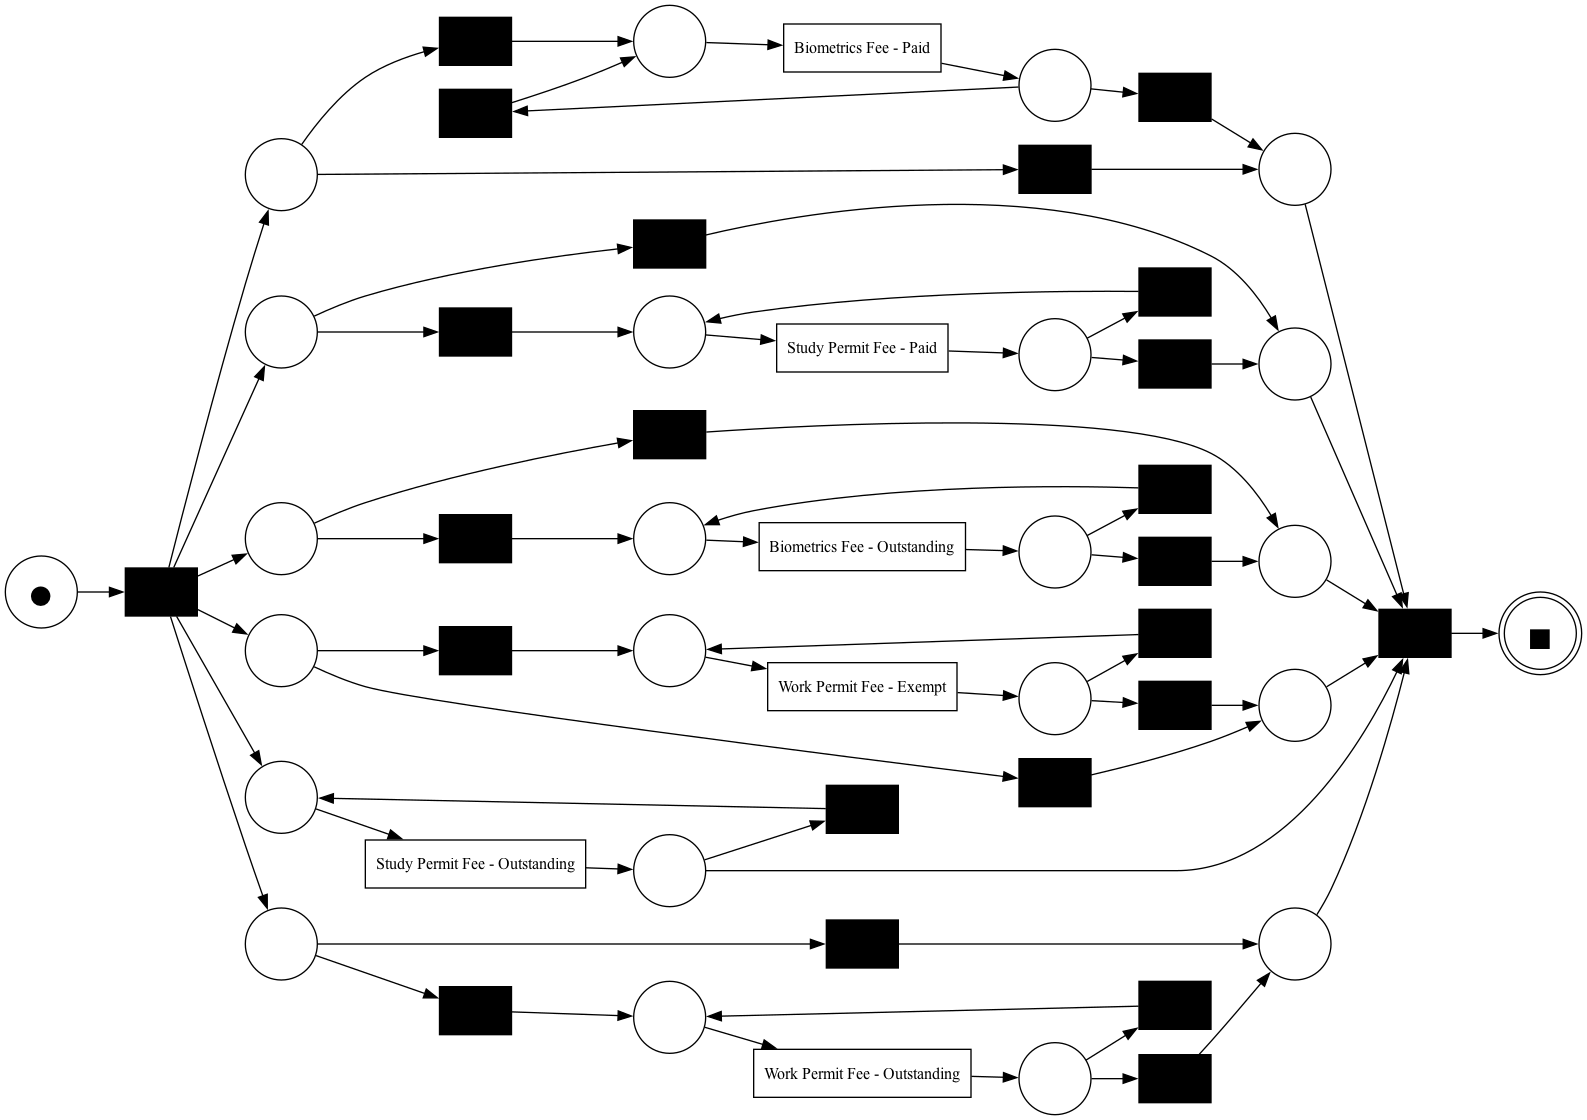

In [79]:
from mine_utils import mine_induct
mine_induct(log2)

In [80]:
# log2.to_csv("lifecycles/level1/logs/Fees-all.csv")
# xes_export.apply(log2, "lifecycles/level1/xes/Fees-all.xes")

In [81]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log2)
vars = get_covering_variants(90, var_stats)
log3 = filter_traces_on_variants(log2, vars)

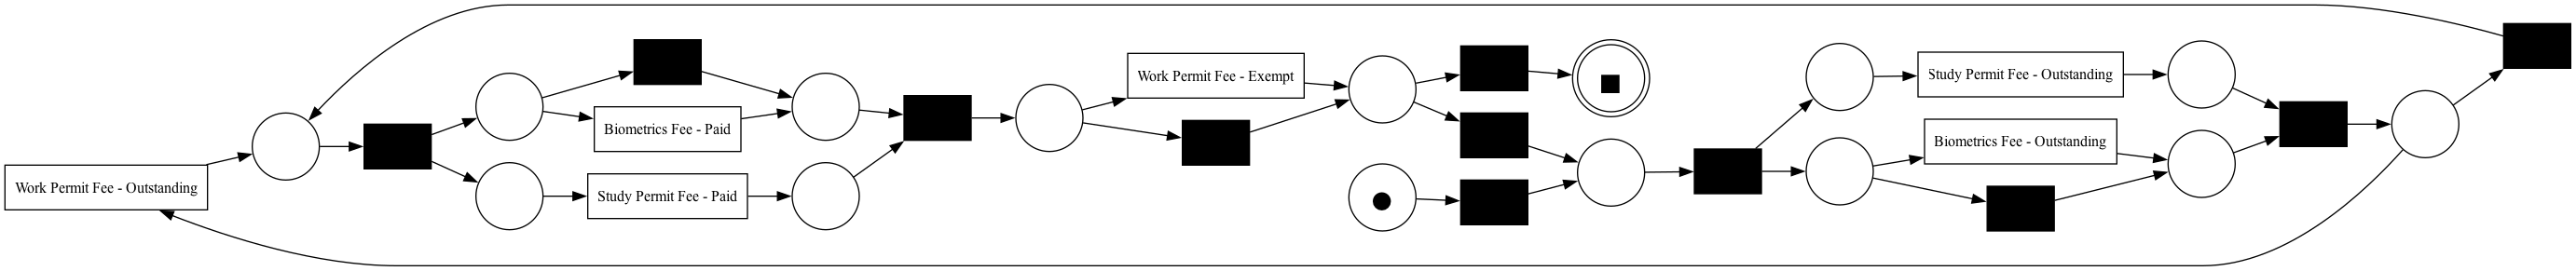

In [82]:
from mine_utils import mine_induct
mine_induct(log3)

In [83]:
log3.to_csv("lifecycles/level1/logs/Fees.csv")
xes_export.apply(log3, "lifecycles/level1/xes/Fees.xes")

exporting log, completed traces ::   0%|          | 0/4888 [00:00<?, ?it/s]

In [84]:
itemset = log2['concept:name'].unique()
itemset

array(['Biometrics Fee - Outstanding', 'Study Permit Fee - Outstanding',
       'Biometrics Fee - Paid', 'Study Permit Fee - Paid',
       'Work Permit Fee - Outstanding', 'Work Permit Fee - Exempt'],
      dtype=object)

In [85]:
max_timedelta = 0 # 1 * 60 # * pow(10,9) # nano to seconds
_ = aggregate_events(log2, itemset, max_timedelta)

# most are simultaneous ...

5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
# groups: 9127 total size: 42318 avg size: 4.64
# groups: 9127 # simult: 9081 avg: 99.5 %
# groups: 9127 avg_diff: 5567 s ( 92 m )


### Other

In [86]:
log[log['concept:name'].str.contains("Application Transfer")]['concept:name'].unique()

array(['Application Transfer - Transferred'], dtype=object)

In [87]:
log[log['concept:name'].str.contains("Eligibility")]['concept:name'].unique()

array(['Eligibility Assessment [start]', 'Eligibility Assessment [end]'],
      dtype=object)

### Replace

In [88]:
# per case, replaces all subprocesses with a single start+end
def implode_subprocess(name, subproc_cond, log):
    log_filt = log[subproc_cond]
    
    # per case, for the subprocesses, replace all activity lifecycle events by single start & end event
    sorted_grouped = log_filt.sort_values(['case:concept:name', 'time:timestamp']).groupby('case:concept:name')
    start_evts = sorted_grouped.first().reset_index(); start_evts['concept:name'] = name + ' [start]'
    end_evts = sorted_grouped.last().reset_index(); end_evts['concept:name'] = name + ' [end]'
    abstract_log = pd.concat([start_evts, end_evts])
    # abstract_log = end_evts 
    
    others = log[~ subproc_cond]
    abstract_log = pd.concat([ abstract_log, others ], ignore_index=True).sort_values(by=['case:concept:name','time:timestamp'])
    
    return abstract_log

In [89]:
a_log = log

In [90]:
cond = (a_log['concept:name'].str.contains("Candidate")) | a_log['concept:name'].str.contains("Integrated")

a_log = implode_subprocess("Candidate/Integrated Search", cond, a_log)
# a_log[(a_log['concept:name'].str.contains("Candidate")) | a_log['concept:name'].str.contains("Integrated")]

In [91]:
cond = ((a_log['concept:name'].str.contains("Biometric")) | a_log['concept:name'].str.contains("Biographic")) & (~ a_log['concept:name'].str.contains("Fee"))

a_log = implode_subprocess("Biometric/Biographic", cond, a_log)
# a_log[((a_log['concept:name'].str.contains("Biometric")) | a_log['concept:name'].str.contains("Biographic")) & (~ a_log['concept:name'].str.contains("Fee"))]

In [92]:
cond = a_log['concept:name'].str.contains("Medical")

a_log = implode_subprocess("Medical (Assessment)", cond, a_log)
# a_log[a_log['concept:name'].str.contains("Medical")]

In [93]:
cond = a_log['concept:name'].str.contains("Criminality")

a_log = implode_subprocess("Criminality (Assessment)", cond, a_log)
# a_log[a_log['concept:name'].str.contains("Criminality")]

In [94]:
cond = a_log['concept:name'].str.contains("Fee")

a_log = implode_subprocess("Fees", cond, a_log)
# a_log[a_log['concept:name'].str.contains("Fee")]

In [95]:
a_log.to_csv("abstract_log-starts_ends-v2.csv")

## Mine models for (sub)processes

### Mine models for subprocesses

In [ ]:
def init_subdir(subdir):
    if os.path.exists(subdir):
        shutil.rmtree(subdir)
    os.mkdir(subdir)

In [107]:
def save_entries_json(names, default_format, path):
    all = "[" + ", ".join(map(lambda n: f"\"{n}\"", names)) + "]"
    prefs = "{" + ", ".join(map(lambda n: f"\"{n}\": \"{default_format}\"", names)) + "}"
    obj = f"{{ \"all\": {all}, \"prefs\": {prefs} }}"
    open(os.path.join(path, "graphs.json"), "w").write(obj)

In [ ]:
# for subprocess logs, mine process models & xes

import os, shutil
from mine_utils import mine_dfg, mine_heur, mine_alpha, mine_induct
import pm4py.objects.log.exporter.xes.exporter as xes_export

default_format = "heur"
# fill in level!
subdir = "lifecycles/level1"
    
init_subdir(os.path.join(subdir, "dfg"))
init_subdir(os.path.join(subdir, "alpha"))
init_subdir(os.path.join(subdir, "heur"))
init_subdir(os.path.join(subdir, "induct"))
init_subdir(os.path.join(subdir, "xes"))

names = []
for file in os.listdir(os.path.join(subdir, "logs")):
    if file.endswith(".csv"):
        name = file[0: file.index(".csv")]
        print(name)
        names.append(name)
        
        log = pd.read_csv(os.path.join(subdir, "logs", name + ".csv"))
        log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])
        mine_dfg(log, os.path.join(subdir, "dfg", name), True)
        mine_heur(log, os.path.join(subdir, "heur", name), True)
        mine_alpha(log, os.path.join(subdir, "alpha", name), True)
        mine_induct(log, True, os.path.join(subdir, "induct", name), True)
        xes_export.apply(log, os.path.join(subdir, "xes", name + ".xes"))

save_entries_json(names, default_format, subdir)

Candidate_Integrated Search


exporting log, completed traces ::   0%|          | 0/5746 [00:00<?, ?it/s]

Biometric_Biographic


exporting log, completed traces ::   0%|          | 0/5051 [00:00<?, ?it/s]

Fees


exporting log, completed traces ::   0%|          | 0/4888 [00:00<?, ?it/s]

Medical (Assessment)


exporting log, completed traces ::   0%|          | 0/2005 [00:00<?, ?it/s]

Criminality (Assessment)


exporting log, completed traces ::   0%|          | 0/5428 [00:00<?, ?it/s]

287

### Mine models for main process

In [ ]:
# for overall log, save xes

nr = "v2"

import pm4py.objects.log.exporter.xes.exporter as xes_export

log = pd.read_csv(f"abstract_log-starts_ends-{nr}.csv")
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

default_format = "dcr"
subdir = "lifecycles/level0"

init_subdir(os.path.join(subdir, "logs"))
init_subdir(os.path.join(subdir, "dfg"))
init_subdir(os.path.join(subdir, "alpha"))
init_subdir(os.path.join(subdir, "heur"))
init_subdir(os.path.join(subdir, "induct"))
init_subdir(os.path.join(subdir, "xes"))

name = "main"
log.to_csv(os.path.join(subdir, "logs", name + ".csv"))
mine_dfg(log, os.path.join(subdir, "dfg", name), True)
mine_heur(log, os.path.join(subdir, "heur", name), True)
mine_alpha(log, os.path.join(subdir, "alpha", name), True)
mine_induct(log, True, os.path.join(subdir, "induct", name), True)
xes_export.apply(log, os.path.join(subdir, "xes", name + ".xes"))

save_entries_json([name], default_format, subdir)

exporting log, completed traces ::   0%|          | 0/5800 [00:00<?, ?it/s]

### Fix petri nets

In [110]:
# fix start, end labels of petri nets

# label=<&#9679;> fillcolor=white fixedsize=true fontsize=34
# -> label="start" fillcolor=white fixedsize=true fontsize=18
# 
# label=<&#9632;> fillcolor=white fixedsize=true fontsize=32
# -> label="end" fillcolor=white fixedsize=true fontsize=18

import os

def fix_petrinets(path, to_repls, repls):
    for dirpath, _, filenames in os.walk(path):
        for filename in filenames:
            if not filename.endswith(".gv"):
                continue
            filepath = os.path.join(dirpath, filename)
            print(filepath)
            with open(filepath) as f:
                s = f.read()
            for to_repl, repl in zip(to_repls, repls):
                s = s.replace(to_repl, repl)
            with open(filepath, "w") as f:
                f.write(s)


to_repls = [ "label=<&#9679;> fillcolor=white fixedsize=true fontsize=34", "label=<&#9632;> fillcolor=white fixedsize=true fontsize=32" ]
repls = [ "label=\"start\" fillcolor=white fixedsize=true fontsize=18", "label=\"end\" fillcolor=white fixedsize=true fontsize=18" ]

fix_petrinets("lifecycles/level0/alpha", to_repls, repls)
fix_petrinets("lifecycles/level0/induct", to_repls, repls)
fix_petrinets("lifecycles/level1/alpha", to_repls, repls)
fix_petrinets("lifecycles/level1/induct", to_repls, repls)
fix_petrinets("lifecycles/level2/alpha", to_repls, repls)
fix_petrinets("lifecycles/level2/induct", to_repls, repls)

lifecycles/level0/alpha/main.gv
lifecycles/level0/induct/main.gv
lifecycles/level1/alpha/Medical (Assessment).gv
lifecycles/level1/alpha/Criminality (Assessment).gv
lifecycles/level1/alpha/Biometric_Biographic.gv
lifecycles/level1/alpha/Candidate_Integrated Search.gv
lifecycles/level1/alpha/Fees.gv
lifecycles/level1/induct/Medical (Assessment).gv
lifecycles/level1/induct/Criminality (Assessment).gv
lifecycles/level1/induct/Biometric_Biographic.gv
lifecycles/level1/induct/Candidate_Integrated Search.gv
lifecycles/level1/induct/Fees.gv
lifecycles/level2/alpha/Candidate ID Decision.gv
lifecycles/level2/alpha/Biometric - FCC Detail - USA.gv
lifecycles/level2/alpha/Criminality.gv
lifecycles/level2/alpha/Biometric - FCC - USA.gv
lifecycles/level2/alpha/Criminality Assessment.gv
lifecycles/level2/alpha/Eligibility Assessment.gv
lifecycles/level2/alpha/Integrated Search.gv
lifecycles/level2/alpha/Biographic.gv
lifecycles/level2/alpha/Biometrics - RCMP.gv
lifecycles/level2/alpha/Auto Promote De